In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import glob
import cv2
import time
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
import tensorflow as tf
import tensorflow.keras as kr
from tensorflow.keras import datasets, models 
from tensorflow.keras import layers, activations, initializers
from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras.engine.input_spec import InputSpec

# Hypercomplex-valued dense and conv2d layers:

In [4]:
class HyperDense(layers.Layer):
    def __init__(self, units,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 algebra = np.array([[-1,+1,-1],[-1,-1,1],[1,-1,-1]]) # Quaternion algebra
                ):
        super(HyperDense, self).__init__()
        self.units = int(units) if not isinstance(units, int) else units
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.algebra = algebra
               

    def build(self, input_shape):
        assert input_shape[-1] % 4 == 0
        input_dim = input_shape[-1] // 4
        
        # Real-part of the weights
        self.kernel_r = self.add_weight(
            shape=(input_dim, self.units),
            initializer="glorot_normal",
            trainable=True,
        )
        # Imaginary-part of the weights
        self.kernel_i = self.add_weight(
            shape=(input_dim, self.units),
            initializer="glorot_normal",
            trainable=True,
        )
        self.kernel_j = self.add_weight(
            shape=(input_dim, self.units),
            initializer="glorot_normal",
            trainable=True,
        )
        self.kernel_k = self.add_weight(
            shape=(input_dim, self.units),
            initializer="glorot_normal",
            trainable=True,
        )
        
        # Quaternion-valued bias
        if self.use_bias:
            self.bias = self.add_weight(
                shape=(4*self.units,), initializer="zeros", trainable=True
                )
        else:
            self.bias = None

    def call(self, inputs):
        W_r = tf.concat([self.kernel_r,self.algebra[0,0]*self.kernel_i,self.algebra[1,1]*self.kernel_j,self.algebra[2,2]*self.kernel_k],axis=0)
        W_i = tf.concat([self.kernel_i,self.kernel_r,self.algebra[1,2]*self.kernel_k,self.algebra[2,1]*self.kernel_j],axis=0)
        W_j = tf.concat([self.kernel_j,self.algebra[0,2]*self.kernel_k,self.kernel_r,self.algebra[2,0]*self.kernel_i],axis=0)
        W_k = tf.concat([self.kernel_k,self.algebra[0,1]*self.kernel_j,self.algebra[1,0]*self.kernel_i,self.kernel_r],axis=0)
        W = tf.concat([W_r,W_i,W_j,W_k],axis=1)
        outputs = tf.matmul(inputs, W)
        
        if self.use_bias:
            outputs = tf.nn.bias_add(outputs, self.bias)

        if self.activation is not None:
            outputs = self.activation(outputs)
        
        return outputs

In [5]:
class HyperConv2D(layers.Layer):
    def __init__(self, 
                 filters, 
                 kernel_size, 
                 strides=1, 
                 padding='VALID',
                 use_bias=True,
                 activation=None,
                 initializer='glorot_normal',
                 data_format=None,
                 algebra = np.array([[-1,+1,-1],[-1,-1,1],[1,-1,-1]]) # Quaternion algebra
                ):
        super(HyperConv2D, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.use_bias = use_bias
        self.activation = activations.get(activation)
        self.initializer = initializers.get(initializer)
        self.data_format = data_format
        self.algebra = algebra
        
    def _get_channel_axis(self):
        if self.data_format == 'channels_first':
            raise ValueError('HyperConv2d is designed only for channels_last. '
                             'The input must be changed to channels last!')
        else:
            return -1
    
    def _get_input_channel(self, input_shape):
        channel_axis = self._get_channel_axis()
        if input_shape.dims[channel_axis].value is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        return int(input_shape[channel_axis])

    def build(self, input_shape):
        input_shape = tensor_shape.TensorShape(input_shape)
        input_channel = self._get_input_channel(input_shape)
        if input_channel % 4 != 0:
            raise ValueError('The number of input channels must be divisible by 4.')
    
        input_dim = input_channel // 4
        kernel_shape = self.kernel_size + (input_dim, self.filters)
        
        self.kernel_r = self.add_weight(
            name='real_kernel',
            shape=kernel_shape,
            initializer=self.initializer,
            trainable=True,
        )
        self.kernel_i = self.add_weight(
            name='imag_i_kernel',
            shape=kernel_shape,
            initializer=self.initializer,
            trainable=True,
        )
        self.kernel_j = self.add_weight(
            name='imag_j_kernel',
            shape=kernel_shape,
            initializer=self.initializer,
            trainable=True,
        )
        self.kernel_k = self.add_weight(
            name='imag_k_kernel',
            shape=kernel_shape,
            initializer=self.initializer,
            trainable=True,
        )
        
        if self.use_bias:
            self.bias = self.add_weight(
                name='bias',
                shape=(4*self.filters,),
                initializer="zeros",
                trainable=True,
                dtype=self.dtype)
        else:
            self.bias = None

    def call(self, inputs):        
        # Filter multiplied from the right!
        F_r = tf.concat([self.kernel_r,self.algebra[0,0]*self.kernel_i,self.algebra[1,1]*self.kernel_j,self.algebra[2,2]*self.kernel_k],axis=2)
        F_i = tf.concat([self.kernel_i,self.kernel_r,self.algebra[1,2]*self.kernel_k,self.algebra[2,1]*self.kernel_j],axis=2)
        F_j = tf.concat([self.kernel_j,self.algebra[0,2]*self.kernel_k,self.kernel_r,self.algebra[2,0]*self.kernel_i],axis=2)
        F_k = tf.concat([self.kernel_k,self.algebra[0,1]*self.kernel_j,self.algebra[1,0]*self.kernel_i,self.kernel_r],axis=2)
               
        y_r = tf.nn.conv2d(inputs, F_r, strides=self.strides, padding=self.padding)
        y_i = tf.nn.conv2d(inputs, F_i, strides=self.strides, padding=self.padding)
        y_j = tf.nn.conv2d(inputs, F_j, strides=self.strides, padding=self.padding)
        y_k = tf.nn.conv2d(inputs, F_k, strides=self.strides, padding=self.padding)
        
        outputs = tf.concat([y_r, y_i, y_j, y_k],axis=3)
        
        if self.use_bias:
            outputs = tf.nn.bias_add(outputs,self.bias)
            
        if self.activation is not None:
            outputs = self.activation(outputs)
        
        return outputs

# Load the dataset using RGB and HSV encodings:

Change the dataset_pah accordingly!

In [6]:
image_size = (126,126)
dataset_path = "/content/gdrive/MyDrive/Datasets/ALL_IDB/ALL_IDB2/img/*.tif"

imgs_list = [f for f in glob.glob(dataset_path)]
N = len(imgs_list)
print("Number of images:",N)

Xr_rgb = np.zeros((N,image_size[0],image_size[1],3))
Xq_rgb = np.zeros((N,image_size[0],image_size[1],4))
Xr_hsv = np.zeros((N,image_size[0],image_size[1],3))
Xq_hsv = np.zeros((N,image_size[0],image_size[1],4))
y = np.zeros((N,))

z = np.zeros((image_size[0],image_size[1],1))
for i,img_path in enumerate(imgs_list):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, image_size)

    # RGB images
    Xr_rgb[i,:,:,:] = img_resized/255
    Xq_rgb[i,:,:,:] = np.concatenate([z,img_resized/255],axis=2)
    
    # Convert to HSV
    img_hsv = cv2.cvtColor(img_resized, cv2.COLOR_RGB2HSV)
    H = np.reshape((2*np.pi/180)*img_hsv[:,:,0],(image_size[0],image_size[1],1))
    S = np.reshape(img_hsv[:,:,1]/255,(image_size[0],image_size[1],1))
    V = np.reshape(img_hsv[:,:,2]/255,(image_size[0],image_size[1],1))
    
    # Real-valued images;
    Xr_hsv[i,:,:,:] = np.concatenate([H,S,V],axis=2)

    # Quaternion-valued images obtained using HSV;
    Xq_hsv[i,:,:,:] = np.concatenate([np.cos(H)*S,np.cos(H)*V,np.sin(H)*S,np.sin(H)*V],axis=2)
    
    ind = img_path.find(".tif")
    y[i] = int(img_path[ind-1])
    
print("Number of lymphoblasts:",int(np.sum(y)))

Number of images: 260
Number of lymphoblasts: 130


## Show a sample image

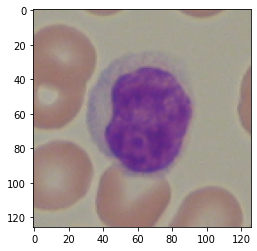

In [7]:
plt.imshow(Xr_rgb[3,:,:,:])

# Partitionate the dataset

In [8]:
indtr, indte, ytr, yte = train_test_split(range(260), y, test_size=0.5)

In [9]:
Results = np.zeros((7,2))
Models = ['Real','C(0,2)-Equiv','C(1,1)-Equiv','C(2,0)-Equiv','C(0,2)-Small','C(1,1)-Small','C(2,0)-Small']

# Evaluate a real-valued network with RGB encoding

Select RGB images for train and test:

In [10]:
Xtr = Xr_rgb[indtr]
Xte = Xr_rgb[indte]

Construc and train the RGB real-valued network:

In [11]:
tf.keras.backend.clear_session()
       
model_real = kr.Sequential(
        [
            layers.Conv2D(8, kernel_size=(3, 3), activation="relu", input_shape=Xtr.shape[1:]),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(1, activation=None)
        ]
    )

model_real.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 16)       0

In [12]:
Nepochs = 300

model_real.compile(optimizer='adam',
      loss=kr.losses.BinaryCrossentropy(from_logits=True),
      metrics=[kr.metrics.BinaryAccuracy()])

datagen = kr.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True)
datagen.fit(Xtr)
it = datagen.flow(Xtr, ytr, batch_size=32)
batch = it.next()

start = time.process_time()
hist = model_real.fit(datagen.flow(Xtr, ytr, batch_size=32),epochs=Nepochs, verbose=1, validation_data=(Xte,yte))
elapsed = (time.process_time() - start)

Acc_tr = accuracy_score(ytr,model_real.predict(Xtr).flatten()>=0)
Acc_te = accuracy_score(yte,model_real.predict(Xte).flatten()>=0)

Results[0,:] = np.array([Acc_tr,Acc_te])

print("Real-valued Accuracy (Train/Test) = %2.2f/%2.2f -- Time: %2.3f(s)." % (Acc_tr,Acc_te,elapsed))

Epoch 1/300
5/5 [==============================] - 13s 117ms/step - loss: 0.7059 - binary_accuracy: 0.4692 - val_loss: 0.7060 - val_binary_accuracy: 0.5385
Epoch 2/300
5/5 [==============================] - 0s 25ms/step - loss: 0.6868 - binary_accuracy: 0.4846 - val_loss: 0.7083 - val_binary_accuracy: 0.5385
Epoch 3/300
5/5 [==============================] - 0s 25ms/step - loss: 0.6860 - binary_accuracy: 0.4538 - val_loss: 0.7025 - val_binary_accuracy: 0.5385
Epoch 4/300
5/5 [==============================] - 0s 21ms/step - loss: 0.6877 - binary_accuracy: 0.4615 - val_loss: 0.6982 - val_binary_accuracy: 0.5385
Epoch 5/300
5/5 [==============================] - 0s 22ms/step - loss: 0.6916 - binary_accuracy: 0.4615 - val_loss: 0.6964 - val_binary_accuracy: 0.5385
Epoch 6/300
5/5 [==============================] - 0s 40ms/step - loss: 0.6798 - binary_accuracy: 0.4615 - val_loss: 0.6942 - val_binary_accuracy: 0.5385
Epoch 7/300
5/5 [==============================] - 0s 38ms/step - loss: 0.

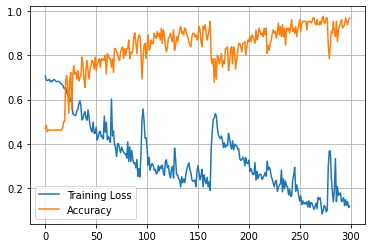

In [13]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['binary_accuracy'], label='Accuracy')
plt.grid()
plt.legend()

Real-valued Accuracy (Train/Test) = 0.99/0.95 -- Time: 54.591(s).


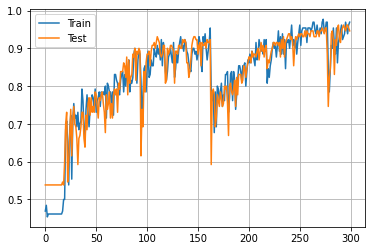

In [14]:
plt.plot(hist.history['binary_accuracy'], label='Train')
plt.plot(hist.history['val_binary_accuracy'], label='Test')
plt.grid()
plt.legend()

print("Real-valued Accuracy (Train/Test) = %2.2f/%2.2f -- Time: %2.3f(s)." % (Acc_tr,Acc_te,elapsed))

# Evaluate a Quaternion-valued (Cl(0,2)-valued) Equivalent Network with HSV encoding

Select 4D-HSV images for train and test:

In [15]:
Xtr = Xq_hsv[indtr]
Xte = Xq_hsv[indte]

Construc and train the HSV quaternion-valued network:

In [16]:
tf.keras.backend.clear_session()

quaternions = np.array([[-1,+1,-1],[-1,-1,1],[1,-1,-1]]) # Quaternion algebra multiplication table

datagen = kr.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True)
datagen.fit(Xtr)
it = datagen.flow(Xtr, ytr, batch_size=32)
batch = it.next()

model_hyper = kr.Sequential(
    [
        layers.Input(shape=Xtr.shape[1:]),
        HyperConv2D(4, kernel_size=(3, 3), activation="relu", algebra = quaternions),
        layers.MaxPooling2D(pool_size=(2, 2)),
        HyperConv2D(8, kernel_size=(3, 3), activation="relu", algebra = quaternions),
        layers.MaxPooling2D(pool_size=(2, 2)),
        HyperConv2D(8, kernel_size=(3, 3), activation="relu", algebra = quaternions),
        layers.MaxPooling2D(pool_size=(2, 2)),
        HyperConv2D(16, kernel_size=(3, 3), activation="relu", algebra = quaternions),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(1, activation=None),
    ]
)

model_hyper.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hyper_conv2d (HyperConv2D)  (None, 124, 124, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 16)       0         
 )                                                               
                                                                 
 hyper_conv2d_1 (HyperConv2D  (None, 60, 60, 32)       1184      
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 hyper_conv2d_2 (HyperConv2D  (None, 28, 28, 32)       2336      
 )                                                      

In [17]:
print("Percentage of the real-valued parameters: %2.1f" % (100*model_hyper.count_params()/model_real.count_params()))

Percentage of the real-valued parameters: 112.1


In [18]:
Nepochs = 300

model_hyper.compile(optimizer='adam',
              loss=kr.losses.BinaryCrossentropy(from_logits=True),
              metrics=[kr.metrics.BinaryAccuracy()])

start = time.process_time()
hist = model_hyper.fit(datagen.flow(Xtr, ytr, batch_size=32),epochs=Nepochs, verbose=1, validation_data=(Xte,yte))
elapsed = (time.process_time() - start)

Acc_tr = accuracy_score(ytr,model_hyper.predict(Xtr).flatten()>=0)
Acc_te = accuracy_score(yte,model_hyper.predict(Xte).flatten()>=0)

Results[1,:] = np.array([Acc_tr,Acc_te])

print("Quaternion-valued Equivalent Accuracy (Train/Test) = %2.2f/%2.2f -- Time: %2.3f(s)." % (Acc_tr,Acc_te,elapsed))

Epoch 1/300
5/5 [==============================] - 3s 150ms/step - loss: 0.7863 - binary_accuracy: 0.5385 - val_loss: 0.5757 - val_binary_accuracy: 0.7692
Epoch 2/300
5/5 [==============================] - 0s 36ms/step - loss: 0.6218 - binary_accuracy: 0.7077 - val_loss: 0.5685 - val_binary_accuracy: 0.7692
Epoch 3/300
5/5 [==============================] - 0s 37ms/step - loss: 0.5329 - binary_accuracy: 0.7538 - val_loss: 0.4520 - val_binary_accuracy: 0.7769
Epoch 4/300
5/5 [==============================] - 0s 35ms/step - loss: 0.4514 - binary_accuracy: 0.7692 - val_loss: 0.4119 - val_binary_accuracy: 0.7923
Epoch 5/300
5/5 [==============================] - 0s 35ms/step - loss: 0.4377 - binary_accuracy: 0.7538 - val_loss: 0.3889 - val_binary_accuracy: 0.8000
Epoch 6/300
5/5 [==============================] - 0s 39ms/step - loss: 0.3891 - binary_accuracy: 0.7846 - val_loss: 0.3771 - val_binary_accuracy: 0.8308
Epoch 7/300
5/5 [==============================] - 0s 39ms/step - loss: 0.3

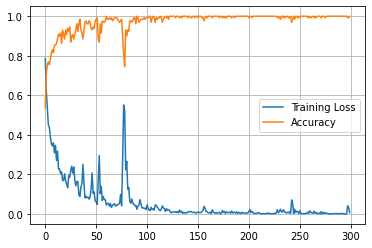

In [19]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['binary_accuracy'], label='Accuracy')
plt.grid()
plt.legend()

Quaternion-valued Equivalent Accuracy (Train/Test) = 1.00/0.97 -- Time: 69.649(s).


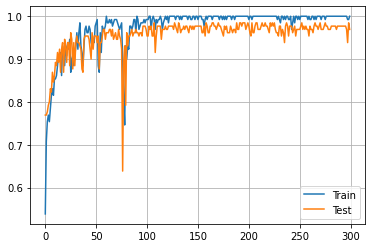

In [20]:
plt.plot(hist.history['binary_accuracy'], label='Train')
plt.plot(hist.history['val_binary_accuracy'], label='Test')
plt.grid()
plt.legend()

print("Quaternion-valued Equivalent Accuracy (Train/Test) = %2.2f/%2.2f -- Time: %2.3f(s)." % (Acc_tr,Acc_te,elapsed))

# Evaluate a Cl(1,1)-valued Equivalent Network with HSV encoding

We use the same partition used in the HSV quaternion-valued network.

In [21]:
tf.keras.backend.clear_session()

Cl1_1 = np.array([[+1,+1,+1],[-1,-1,+1],[-1,-1,+1]]) # Cl(1,1) algebra

datagen = kr.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True)
datagen.fit(Xtr)
it = datagen.flow(Xtr, ytr, batch_size=32)
batch = it.next()

model_hyper = kr.Sequential(
    [
        layers.Input(shape=Xtr.shape[1:]),
        HyperConv2D(4, kernel_size=(3, 3), activation="relu", algebra = Cl1_1),
        layers.MaxPooling2D(pool_size=(2, 2)),
        HyperConv2D(8, kernel_size=(3, 3), activation="relu", algebra = Cl1_1),
        layers.MaxPooling2D(pool_size=(2, 2)),
        HyperConv2D(8, kernel_size=(3, 3), activation="relu", algebra = Cl1_1),
        layers.MaxPooling2D(pool_size=(2, 2)),
        HyperConv2D(16, kernel_size=(3, 3), activation="relu", algebra = Cl1_1),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(1, activation=None),
    ]
)

model_hyper.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hyper_conv2d (HyperConv2D)  (None, 124, 124, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 16)       0         
 )                                                               
                                                                 
 hyper_conv2d_1 (HyperConv2D  (None, 60, 60, 32)       1184      
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 hyper_conv2d_2 (HyperConv2D  (None, 28, 28, 32)       2336      
 )                                                      

In [22]:
print("Percentage of the real-valued parameters: %2.1f" % (100*model_hyper.count_params()/model_real.count_params()))

Percentage of the real-valued parameters: 112.1


In [23]:
Nepochs = 300

model_hyper.compile(optimizer='adam',
              loss=kr.losses.BinaryCrossentropy(from_logits=True),
              metrics=[kr.metrics.BinaryAccuracy()])

start = time.process_time()
hist = model_hyper.fit(datagen.flow(Xtr, ytr, batch_size=32),epochs=Nepochs, verbose=1,validation_data=(Xte,yte))
elapsed = (time.process_time() - start)

Results[2,:] = np.array([Acc_tr,Acc_te])

Acc_tr = accuracy_score(ytr,model_hyper.predict(Xtr).flatten()>=0)
Acc_te = accuracy_score(yte,model_hyper.predict(Xte).flatten()>=0)

print("Cl(1,1)-valued Equivalent Accuracy (Train/Test) = %2.2f/%2.2f -- Time: %2.3f(s)." % (Acc_tr,Acc_te,elapsed))

Epoch 1/300
5/5 [==============================] - 2s 138ms/step - loss: 0.7016 - binary_accuracy: 0.6000 - val_loss: 0.5162 - val_binary_accuracy: 0.7769
Epoch 2/300
5/5 [==============================] - 0s 43ms/step - loss: 0.5500 - binary_accuracy: 0.7692 - val_loss: 0.4971 - val_binary_accuracy: 0.7846
Epoch 3/300
5/5 [==============================] - 0s 41ms/step - loss: 0.4597 - binary_accuracy: 0.7692 - val_loss: 0.3934 - val_binary_accuracy: 0.7846
Epoch 4/300
5/5 [==============================] - 0s 37ms/step - loss: 0.4438 - binary_accuracy: 0.7615 - val_loss: 0.3690 - val_binary_accuracy: 0.8231
Epoch 5/300
5/5 [==============================] - 0s 38ms/step - loss: 0.4395 - binary_accuracy: 0.7846 - val_loss: 0.3964 - val_binary_accuracy: 0.8846
Epoch 6/300
5/5 [==============================] - 0s 39ms/step - loss: 0.4329 - binary_accuracy: 0.8000 - val_loss: 0.3788 - val_binary_accuracy: 0.8923
Epoch 7/300
5/5 [==============================] - 0s 39ms/step - loss: 0.3

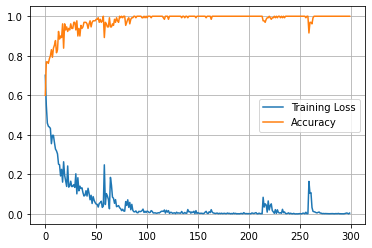

In [24]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['binary_accuracy'], label='Accuracy')
plt.grid()
plt.legend()

Cl(1,1)-valued Equivalent Accuracy (Train/Test) = 1.00/0.98 -- Time: 71.189(s).


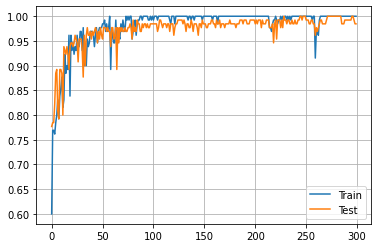

In [25]:
plt.plot(hist.history['binary_accuracy'], label='Train')
plt.plot(hist.history['val_binary_accuracy'], label='Test')
plt.grid()
plt.legend()

print("Cl(1,1)-valued Equivalent Accuracy (Train/Test) = %2.2f/%2.2f -- Time: %2.3f(s)." % (Acc_tr,Acc_te,elapsed))

# Evaluate a Cl(2,0)-valued Equivalent Network with HSV encoding

We use the same partition used in the HSV quaternion-valued network.

In [26]:
tf.keras.backend.clear_session()

Cl2_0 = np.array([[+1,+1,+1],[-1,+1,-1],[-1,+1,-1]]) # Cl(2,0) algebra

datagen = kr.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True)
datagen.fit(Xtr)
it = datagen.flow(Xtr, ytr, batch_size=32)
batch = it.next()

model_hyper = kr.Sequential(
    [
        layers.Input(shape=Xtr.shape[1:]),
        HyperConv2D(4, kernel_size=(3, 3), activation="relu", algebra = Cl2_0),
        layers.MaxPooling2D(pool_size=(2, 2)),
        HyperConv2D(8, kernel_size=(3, 3), activation="relu", algebra = Cl2_0),
        layers.MaxPooling2D(pool_size=(2, 2)),
        HyperConv2D(8, kernel_size=(3, 3), activation="relu", algebra = Cl2_0),
        layers.MaxPooling2D(pool_size=(2, 2)),
        HyperConv2D(16, kernel_size=(3, 3), activation="relu", algebra = Cl2_0),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(1, activation=None),
    ]
)

model_hyper.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hyper_conv2d (HyperConv2D)  (None, 124, 124, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 16)       0         
 )                                                               
                                                                 
 hyper_conv2d_1 (HyperConv2D  (None, 60, 60, 32)       1184      
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 hyper_conv2d_2 (HyperConv2D  (None, 28, 28, 32)       2336      
 )                                                      

In [27]:
print("Percentage of the real-valued parameters: %2.1f" % (100*model_hyper.count_params()/model_real.count_params()))

Percentage of the real-valued parameters: 112.1


In [28]:
Nepochs = 300

model_hyper.compile(optimizer='adam',
              loss=kr.losses.BinaryCrossentropy(from_logits=True),
              metrics=[kr.metrics.BinaryAccuracy()])

start = time.process_time()
hist = model_hyper.fit(datagen.flow(Xtr, ytr, batch_size=32),epochs=Nepochs, verbose=1,validation_data=(Xte,yte))
elapsed = (time.process_time() - start)

Acc_tr = accuracy_score(ytr,model_hyper.predict(Xtr).flatten()>=0)
Acc_te = accuracy_score(yte,model_hyper.predict(Xte).flatten()>=0)

Results[3,:] = np.array([Acc_tr,Acc_te])

print("Cl(2,0)-valued Equivalent Accuracy (Train/Test) = %2.2f/%2.2f -- Time: %2.3f(s)." % (Acc_tr,Acc_te,elapsed))

Epoch 1/300
5/5 [==============================] - 2s 135ms/step - loss: 0.8310 - binary_accuracy: 0.5385 - val_loss: 0.8744 - val_binary_accuracy: 0.4769
Epoch 2/300
5/5 [==============================] - 0s 47ms/step - loss: 0.6340 - binary_accuracy: 0.6615 - val_loss: 0.5129 - val_binary_accuracy: 0.6769
Epoch 3/300
5/5 [==============================] - 0s 40ms/step - loss: 0.4729 - binary_accuracy: 0.7615 - val_loss: 0.4613 - val_binary_accuracy: 0.8846
Epoch 4/300
5/5 [==============================] - 0s 38ms/step - loss: 0.5457 - binary_accuracy: 0.7769 - val_loss: 0.5074 - val_binary_accuracy: 0.8308
Epoch 5/300
5/5 [==============================] - 0s 36ms/step - loss: 0.4558 - binary_accuracy: 0.8000 - val_loss: 0.3720 - val_binary_accuracy: 0.8000
Epoch 6/300
5/5 [==============================] - 0s 35ms/step - loss: 0.4191 - binary_accuracy: 0.8077 - val_loss: 0.3612 - val_binary_accuracy: 0.7923
Epoch 7/300
5/5 [==============================] - 0s 35ms/step - loss: 0.3

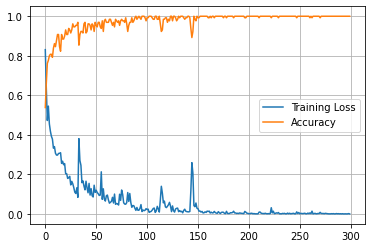

In [29]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['binary_accuracy'], label='Accuracy')
plt.grid()
plt.legend()

Cl(2,0)-valued Equivalent Accuracy (Train/Test) = 1.00/0.98 -- Time: 69.097(s).


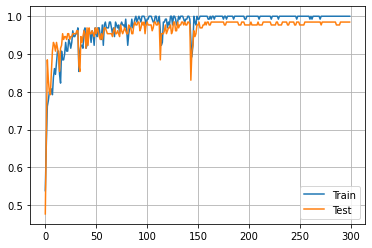

In [30]:
plt.plot(hist.history['binary_accuracy'], label='Train')
plt.plot(hist.history['val_binary_accuracy'], label='Test')
plt.grid()
plt.legend()

print("Cl(2,0)-valued Equivalent Accuracy (Train/Test) = %2.2f/%2.2f -- Time: %2.3f(s)." % (Acc_tr,Acc_te,elapsed))

# Evaluate a Quaternion-valued (Cl(0,2)-valued) Small Network with HSV encoding

Select 4D-HSV images for train and test:

In [31]:
Xtr = Xq_hsv[indtr]
Xte = Xq_hsv[indte]

Construc and train the HSV quaternion-valued network:

In [32]:
tf.keras.backend.clear_session()

quaternions = np.array([[-1,+1,-1],[-1,-1,1],[1,-1,-1]]) # Quaternion algebra multiplication table

datagen = kr.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True)
datagen.fit(Xtr)
it = datagen.flow(Xtr, ytr, batch_size=32)
batch = it.next()

model_hyper = kr.Sequential(
    [
        layers.Input(shape=Xtr.shape[1:]),
        HyperConv2D(2, kernel_size=(3, 3), activation="relu", algebra = quaternions),
        layers.MaxPooling2D(pool_size=(2, 2)),
        HyperConv2D(4, kernel_size=(3, 3), activation="relu", algebra = quaternions),
        layers.MaxPooling2D(pool_size=(2, 2)),
        HyperConv2D(4, kernel_size=(3, 3), activation="relu", algebra = quaternions),
        layers.MaxPooling2D(pool_size=(2, 2)),
        HyperConv2D(8, kernel_size=(3, 3), activation="relu", algebra = quaternions),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(1, activation=None),
    ]
)

model_hyper.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hyper_conv2d (HyperConv2D)  (None, 124, 124, 8)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 8)        0         
 )                                                               
                                                                 
 hyper_conv2d_1 (HyperConv2D  (None, 60, 60, 16)       304       
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 16)       0         
 2D)                                                             
                                                                 
 hyper_conv2d_2 (HyperConv2D  (None, 28, 28, 16)       592       
 )                                                      

In [33]:
print("Percentage of the real-valued parameters: %2.1f" % (100*model_hyper.count_params()/model_real.count_params()))

Percentage of the real-valued parameters: 34.9


In [34]:
Nepochs = 300

model_hyper.compile(optimizer='adam',
              loss=kr.losses.BinaryCrossentropy(from_logits=True),
              metrics=[kr.metrics.BinaryAccuracy()])

start = time.process_time()
hist = model_hyper.fit(datagen.flow(Xtr, ytr, batch_size=32),epochs=Nepochs, verbose=1, validation_data=(Xte,yte))
elapsed = (time.process_time() - start)

Acc_tr = accuracy_score(ytr,model_hyper.predict(Xtr).flatten()>=0)
Acc_te = accuracy_score(yte,model_hyper.predict(Xte).flatten()>=0)

Results[4,:] = np.array([Acc_tr,Acc_te])

print("Quaternion-valued Small Accuracy (Train/Test) = %2.2f/%2.2f -- Time: %2.3f(s)." % (Acc_tr,Acc_te,elapsed))

Epoch 1/300
5/5 [==============================] - 3s 175ms/step - loss: 0.9464 - binary_accuracy: 0.5231 - val_loss: 0.6357 - val_binary_accuracy: 0.7154
Epoch 2/300
5/5 [==============================] - 0s 33ms/step - loss: 0.7550 - binary_accuracy: 0.6154 - val_loss: 0.5679 - val_binary_accuracy: 0.6769
Epoch 3/300
5/5 [==============================] - 0s 33ms/step - loss: 0.6390 - binary_accuracy: 0.6308 - val_loss: 0.5340 - val_binary_accuracy: 0.6846
Epoch 4/300
5/5 [==============================] - 0s 30ms/step - loss: 0.6076 - binary_accuracy: 0.6846 - val_loss: 0.4858 - val_binary_accuracy: 0.8000
Epoch 5/300
5/5 [==============================] - 0s 36ms/step - loss: 0.5382 - binary_accuracy: 0.7000 - val_loss: 0.4808 - val_binary_accuracy: 0.8077
Epoch 6/300
5/5 [==============================] - 0s 30ms/step - loss: 0.4891 - binary_accuracy: 0.7692 - val_loss: 0.4525 - val_binary_accuracy: 0.8385
Epoch 7/300
5/5 [==============================] - 0s 34ms/step - loss: 0.4

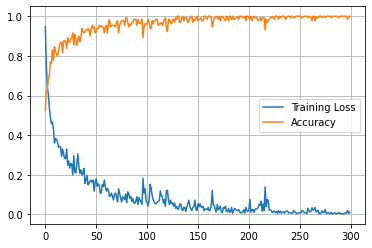

In [35]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['binary_accuracy'], label='Accuracy')
plt.grid()
plt.legend()

Quaternion-valued Small Accuracy (Train/Test) = 1.00/0.97 -- Time: 69.028(s).


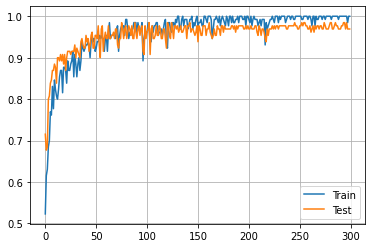

In [36]:
plt.plot(hist.history['binary_accuracy'], label='Train')
plt.plot(hist.history['val_binary_accuracy'], label='Test')
plt.grid()
plt.legend()

print("Quaternion-valued Small Accuracy (Train/Test) = %2.2f/%2.2f -- Time: %2.3f(s)." % (Acc_tr,Acc_te,elapsed))

# Evaluate a Cl(1,1)-valued Small Network with HSV encoding

We use the same partition used in the HSV quaternion-valued network.

In [37]:
tf.keras.backend.clear_session()

Cl1_1 = np.array([[+1,+1,+1],[-1,-1,+1],[-1,-1,+1]]) # Cl(1,1) algebra

datagen = kr.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True)
datagen.fit(Xtr)
it = datagen.flow(Xtr, ytr, batch_size=32)
batch = it.next()

model_hyper = kr.Sequential(
    [
        layers.Input(shape=Xtr.shape[1:]),
        HyperConv2D(2, kernel_size=(3, 3), activation="relu", algebra = Cl1_1),
        layers.MaxPooling2D(pool_size=(2, 2)),
        HyperConv2D(4, kernel_size=(3, 3), activation="relu", algebra = Cl1_1),
        layers.MaxPooling2D(pool_size=(2, 2)),
        HyperConv2D(4, kernel_size=(3, 3), activation="relu", algebra = Cl1_1),
        layers.MaxPooling2D(pool_size=(2, 2)),
        HyperConv2D(8, kernel_size=(3, 3), activation="relu", algebra = Cl1_1),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(1, activation=None),
    ]
)

model_hyper.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hyper_conv2d (HyperConv2D)  (None, 124, 124, 8)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 8)        0         
 )                                                               
                                                                 
 hyper_conv2d_1 (HyperConv2D  (None, 60, 60, 16)       304       
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 16)       0         
 2D)                                                             
                                                                 
 hyper_conv2d_2 (HyperConv2D  (None, 28, 28, 16)       592       
 )                                                      

In [38]:
print("Percentage of the real-valued parameters: %2.1f" % (100*model_hyper.count_params()/model_real.count_params()))

Percentage of the real-valued parameters: 34.9


In [39]:
Nepochs = 300

model_hyper.compile(optimizer='adam',
              loss=kr.losses.BinaryCrossentropy(from_logits=True),
              metrics=[kr.metrics.BinaryAccuracy()])

start = time.process_time()
hist = model_hyper.fit(datagen.flow(Xtr, ytr, batch_size=32),epochs=Nepochs, verbose=1,validation_data=(Xte,yte))
elapsed = (time.process_time() - start)

Acc_tr = accuracy_score(ytr,model_hyper.predict(Xtr).flatten()>=0)
Acc_te = accuracy_score(yte,model_hyper.predict(Xte).flatten()>=0)

Results[5,:] = np.array([Acc_tr,Acc_te])

print("Cl(1,1)-valued Small Accuracy (Train/Test) = %2.2f/%2.2f -- Time: %2.3f(s)." % (Acc_tr,Acc_te,elapsed))

Epoch 1/300
5/5 [==============================] - 2s 117ms/step - loss: 0.9975 - binary_accuracy: 0.5846 - val_loss: 1.0292 - val_binary_accuracy: 0.5077
Epoch 2/300
5/5 [==============================] - 0s 34ms/step - loss: 0.9359 - binary_accuracy: 0.6462 - val_loss: 0.6134 - val_binary_accuracy: 0.6615
Epoch 3/300
5/5 [==============================] - 0s 35ms/step - loss: 0.6539 - binary_accuracy: 0.6923 - val_loss: 0.4905 - val_binary_accuracy: 0.7538
Epoch 4/300
5/5 [==============================] - 0s 35ms/step - loss: 0.5699 - binary_accuracy: 0.6538 - val_loss: 0.4558 - val_binary_accuracy: 0.7615
Epoch 5/300
5/5 [==============================] - 0s 33ms/step - loss: 0.4307 - binary_accuracy: 0.7769 - val_loss: 0.4581 - val_binary_accuracy: 0.8769
Epoch 6/300
5/5 [==============================] - 0s 41ms/step - loss: 0.5260 - binary_accuracy: 0.7308 - val_loss: 0.5237 - val_binary_accuracy: 0.8077
Epoch 7/300
5/5 [==============================] - 0s 39ms/step - loss: 0.5

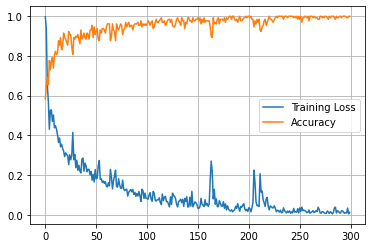

In [40]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['binary_accuracy'], label='Accuracy')
plt.grid()
plt.legend()

Cl(1,1)-valued Small Accuracy (Train/Test) = 1.00/0.98 -- Time: 68.895(s).


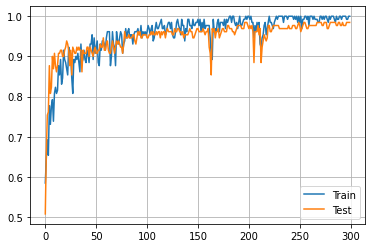

In [41]:
plt.plot(hist.history['binary_accuracy'], label='Train')
plt.plot(hist.history['val_binary_accuracy'], label='Test')
plt.grid()
plt.legend()

print("Cl(1,1)-valued Small Accuracy (Train/Test) = %2.2f/%2.2f -- Time: %2.3f(s)." % (Acc_tr,Acc_te,elapsed))

# Evaluate a Cl(2,0)-valued Small Network with HSV encoding

We use the same partition used in the HSV quaternion-valued network.

In [42]:
tf.keras.backend.clear_session()

Cl2_0 = np.array([[+1,+1,+1],[-1,+1,-1],[-1,+1,-1]]) # Cl(2,0) algebra

datagen = kr.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True)
datagen.fit(Xtr)
it = datagen.flow(Xtr, ytr, batch_size=32)
batch = it.next()

model_hyper = kr.Sequential(
    [
        layers.Input(shape=Xtr.shape[1:]),
        HyperConv2D(2, kernel_size=(3, 3), activation="relu", algebra = Cl2_0),
        layers.MaxPooling2D(pool_size=(2, 2)),
        HyperConv2D(4, kernel_size=(3, 3), activation="relu", algebra = Cl2_0),
        layers.MaxPooling2D(pool_size=(2, 2)),
        HyperConv2D(4, kernel_size=(3, 3), activation="relu", algebra = Cl2_0),
        layers.MaxPooling2D(pool_size=(2, 2)),
        HyperConv2D(8, kernel_size=(3, 3), activation="relu", algebra = Cl2_0),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(1, activation=None),
    ]
)

model_hyper.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hyper_conv2d (HyperConv2D)  (None, 124, 124, 8)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 8)        0         
 )                                                               
                                                                 
 hyper_conv2d_1 (HyperConv2D  (None, 60, 60, 16)       304       
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 16)       0         
 2D)                                                             
                                                                 
 hyper_conv2d_2 (HyperConv2D  (None, 28, 28, 16)       592       
 )                                                      

In [43]:
print("Percentage of the real-valued parameters: %2.1f" % (100*model_hyper.count_params()/model_real.count_params()))

Percentage of the real-valued parameters: 34.9


In [44]:
Nepochs = 300

model_hyper.compile(optimizer='adam',
              loss=kr.losses.BinaryCrossentropy(from_logits=True),
              metrics=[kr.metrics.BinaryAccuracy()])

start = time.process_time()
hist = model_hyper.fit(datagen.flow(Xtr, ytr, batch_size=32),epochs=Nepochs, verbose=1,validation_data=(Xte,yte))
elapsed = (time.process_time() - start)

Acc_tr = accuracy_score(ytr,model_hyper.predict(Xtr).flatten()>=0)
Acc_te = accuracy_score(yte,model_hyper.predict(Xte).flatten()>=0)

Results[6,:] = np.array([Acc_tr,Acc_te])

print("Cl(2,0)-valued Small Accuracy (Train/Test) = %2.2f/%2.2f -- Time: %2.3f(s)." % (Acc_tr,Acc_te,elapsed))

Epoch 1/300
5/5 [==============================] - 2s 131ms/step - loss: 0.8825 - binary_accuracy: 0.4538 - val_loss: 0.7106 - val_binary_accuracy: 0.6077
Epoch 2/300
5/5 [==============================] - 0s 43ms/step - loss: 0.6896 - binary_accuracy: 0.6308 - val_loss: 0.7035 - val_binary_accuracy: 0.5846
Epoch 3/300
5/5 [==============================] - 0s 40ms/step - loss: 0.6631 - binary_accuracy: 0.6154 - val_loss: 0.6411 - val_binary_accuracy: 0.7154
Epoch 4/300
5/5 [==============================] - 0s 36ms/step - loss: 0.6042 - binary_accuracy: 0.6769 - val_loss: 0.5966 - val_binary_accuracy: 0.7846
Epoch 5/300
5/5 [==============================] - 0s 35ms/step - loss: 0.5913 - binary_accuracy: 0.6846 - val_loss: 0.5507 - val_binary_accuracy: 0.8231
Epoch 6/300
5/5 [==============================] - 0s 36ms/step - loss: 0.5280 - binary_accuracy: 0.7077 - val_loss: 0.5196 - val_binary_accuracy: 0.8000
Epoch 7/300
5/5 [==============================] - 0s 37ms/step - loss: 0.5

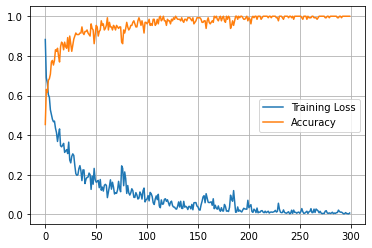

In [45]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['binary_accuracy'], label='Accuracy')
plt.grid()
plt.legend()

Cl(2,0)-valued Small Accuracy (Train/Test) = 1.00/0.97 -- Time: 69.129(s).


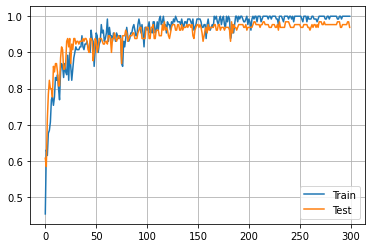

In [46]:
plt.plot(hist.history['binary_accuracy'], label='Train')
plt.plot(hist.history['val_binary_accuracy'], label='Test')
plt.grid()
plt.legend()

print("Cl(2,0)-valued Small Accuracy (Train/Test) = %2.2f/%2.2f -- Time: %2.3f(s)." % (Acc_tr,Acc_te,elapsed))

# Summarty of the results:

In [47]:
df = pd.DataFrame()
df['Models'] = Models
df['Acc. Train'] = Results[:,0]
df['Acc. Test'] = Results[:,1]
df

,Models,Acc. Train,Acc. Test
0,Real,0.992308,0.946154
1,"C(0,2)-Equiv",1.000000,0.969231
2,"C(1,1)-Equiv",1.000000,0.969231
3,"C(2,0)-Equiv",1.000000,0.984615
4,"C(0,2)-Small",1.000000,0.969231
5,"C(1,1)-Small",1.000000,0.984615
6,"C(2,0)-Small",1.000000,0.969231


Try yourself!

Remark: Repete the experiment 100-times to get the results reported in the paper "Clifford Convolutional Neural Networks for Lymphoblast Image Classification" (ICACGA 2022).